In [ ]:
cd "/content/drive/MyDrive/AA Hulse Kemp Lab/Random/FruitQuality"

/content/drive/MyDrive/Work/Hulse Kemp Lab/Random/FruitQuality


In [ ]:
!pip install segmentation_models git+https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models.git to /tmp/pip-req-build-jzdw5_2_
  Running command git clone --filter=blob:none --quiet https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models.git /tmp/pip-req-build-jzdw5_2_
  Resolved https://github.com/JanMarcelKezmann/TensorFlow-Advanced-Segmentation-Models.git to commit c1cfb14840d8f3673c85f7989ece63d5c832605b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 2.4 MB/s eta 0:00:00
  Created wheel for tensorflow-advanced-segmentation-models: filename=tensorflow_advanced_segmentation_models-0.4.10-py3-none-any.whl size=37872 sha256=c11625a5487b6ddd186f1d5cd10438f355ff488652036fd342b841fde7e49594
  Stored in directory: /tmp/pip-ephem-wheel-cache-p8igtrh0/wheels/52/08/25/009a812f8b7a5e048d926236002407487f6f360af86cb887c3
Successfull

In [ ]:
import os

import cv2
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
DATA_DIR = './Images/'
MASK_DIR = './Masks/'

In [ ]:
CLASSES = ['seed', 'pulp', 'albedo', 'flavedo']

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# ds = tf.data.Dataset(os.listdir(DATA_DIR))
ds = tf.data.Dataset.from_tensor_slices(os.listdir(MASK_DIR))

In [ ]:
def process_mask_ids(mask_path):
  return tf.strings.regex_replace(mask_path,".png", "")

ds = ds.map(process_mask_ids, num_parallel_calls=AUTOTUNE)

In [ ]:
for f in ds.take(5):
  print(f)

tf.Tensor(b'FTP.6.60.71_Fruit Quality Fruit1_1_2021-11-17-11-09-34.jpg', shape=(), dtype=string)
tf.Tensor(b'FTP.6.61.44_Fruit Quality Fruit2_1_2021-11-24-09-29-42.jpg', shape=(), dtype=string)
tf.Tensor(b'FTP.6.60.27_Fruit Quality Fruit3_1_2021-11-09-11-44-49.jpg', shape=(), dtype=string)
tf.Tensor(b'FTP.6.60.78_Fruit Quality Fruit5_1_2021-11-17-01-03-54.jpg', shape=(), dtype=string)
tf.Tensor(b'FTP.6.60.66_Fruit Quality Fruit3_1_2021-11-17-10-46-01.jpg', shape=(), dtype=string)


In [ ]:
def decode_img(img, channels=3):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels=channels)

  return tf.image.pad_to_bounding_box(img,0,0, 1024, 1024)

def process_path(file_path):
  # Load the raw data from the file as a string
  img_path = tf.io.read_file(tf.strings.join([DATA_DIR, os.path.sep,file_path]))
  img = decode_img(img_path)

  mask_path = tf.io.read_file(tf.strings.join([MASK_DIR, os.path.sep,file_path, '.png']))
  mask = decode_img(mask_path, channels=1)
  return img, mask

img_ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

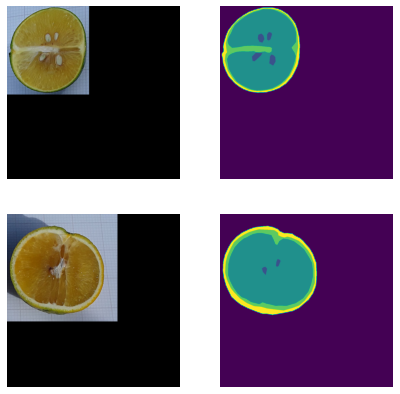

In [ ]:
plt.figure(figsize=(7, 7))
n = 2
for c,(img_, mask_) in enumerate(img_ds.take(n)):
  plt.subplot(n, 2, 2*c+1)
  plt.axis("off")
  plt.imshow(img_.numpy().astype("int32"))
  plt.subplot(n, 2, 2*c+2)
  plt.imshow(mask_.numpy()[:,:,0].astype("int32"))
  plt.axis("off")

In [ ]:
SIZE = len(img_ds)
SIZE

23

In [ ]:
img_ds2 = img_ds.map(lambda x, y: (tf.expand_dims(x, 0), tf.expand_dims(y, 0))) 

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
TRAIN_SIZE = int(0.6 * SIZE)
VAL_SIZE = int(0.2 * SIZE)
LR=0.001

In [ ]:
train_ds = img_ds2.take(TRAIN_SIZE)
val_ds = img_ds2.skip(TRAIN_SIZE).take(VAL_SIZE)
test_ds = img_ds2.skip(TRAIN_SIZE + VAL_SIZE)

In [ ]:
len(train_ds)

13

In [ ]:
len(val_ds)

4

In [ ]:
len(test_ds)

6

In [ ]:
for (image, mask) in train_ds.take(1):
  print(image.shape)

(1, 1024, 1024, 3)


In [ ]:
import tensorflow_advanced_segmentation_models as tasm

In [ ]:
BACKBONE_NAME = "mobilenetv2"
WEIGHTS = "imagenet"
EPOCHS = 40
HEIGHT = 1024
WIDTH = 1024

In [ ]:
base_model, layers, layer_names = tasm.create_base_model(name=BACKBONE_NAME, weights=WEIGHTS, height=HEIGHT, width=WIDTH)

In [ ]:
model = tasm.FCN(n_classes=5, base_model=base_model, output_layers=layers, backbone_trainable=False)
model.compile(tf.keras.optimizers.Adam(0.0001), loss=tasm.losses.CategoricalFocalLoss(), metrics=tasm.metrics.IOUScore(threshold=0.5))

In [ ]:
history = model.fit(
    train_ds,
    batch_size=16,
    epochs=EPOCHS,
    validation_data=val_ds
)

Epoch 1/40
13/13 [==============================] - 37s 2s/step - loss: 13.0909 - iou_score: 0.0899 - val_loss: 8.0804 - val_iou_score: 0.0744
Epoch 2/40
13/13 [==============================] - 23s 2s/step - loss: 11.6083 - iou_score: 0.0367 - val_loss: 7.3090 - val_iou_score: 0.0473
Epoch 3/40
13/13 [==============================] - 26s 2s/step - loss: 10.8309 - iou_score: 0.0141 - val_loss: 6.6456 - val_iou_score: 0.0290
Epoch 4/40
13/13 [==============================] - 26s 2s/step - loss: 10.3950 - iou_score: 0.0077 - val_loss: 6.2065 - val_iou_score: 0.0154
Epoch 5/40
13/13 [==============================] - 33s 3s/step - loss: 10.0828 - iou_score: 0.0052 - val_loss: 5.9391 - val_iou_score: 0.0071
Epoch 6/40
13/13 [==============================] - 30s 2s/step - loss: 9.8502 - iou_score: 0.0035 - val_loss: 5.7828 - val_iou_score: 0.0035
Epoch 7/40
13/13 [==============================] - 25s 2s/step - loss: 9.6695 - iou_score: 0.0027 - val_loss: 5.6923 - val_iou_score: 0.0017
E

In [ ]:
model.save('framework.model')

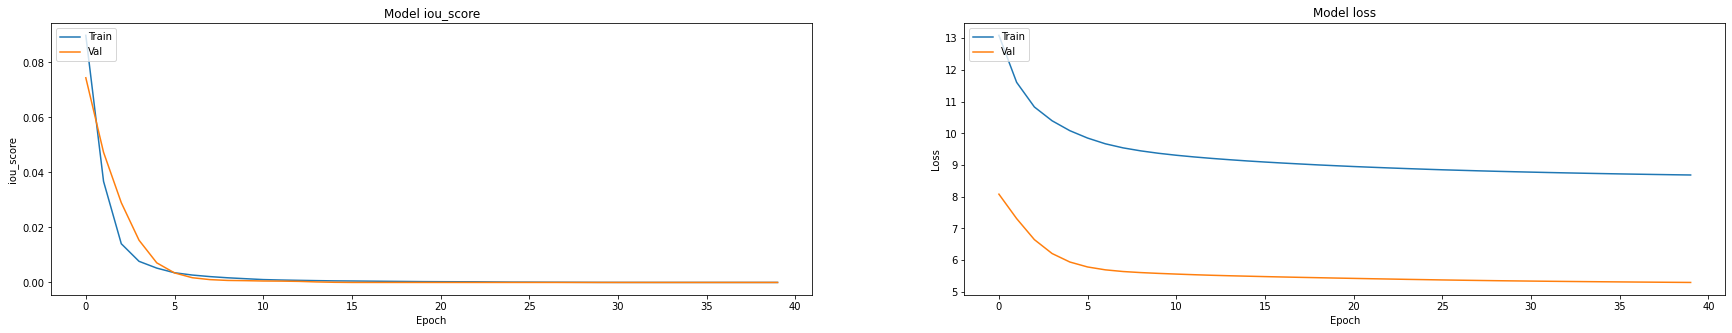

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(test_ds)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip([tasm.metrics.IOUScore(threshold=0.5)], scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

6/6 [==============================] - 10s 1s/step - loss: 12.8369 - iou_score: 1.5876e-04
Loss: 12.837
mean iou_score: 0.00015876


<ipython-input-38-d28b5d4e8b82>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(n, 3, 2*c+1)


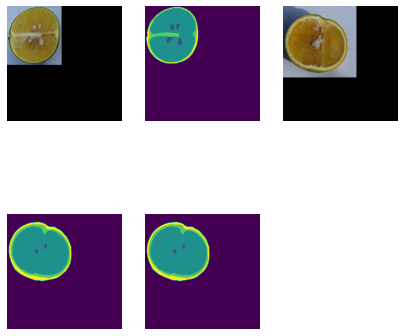

In [ ]:
plt.figure(figsize=(7, 7))
n = 2
for c,(img_, mask_) in enumerate(img_ds.take(n)):
  plt.subplot(n, 3, 2*c+1)
  plt.axis("off")
  plt.imshow(img_.numpy().astype("int32"))
  plt.subplot(n, 3, 2*c+2)
  plt.axis("off")
  plt.imshow(mask_.numpy()[:,:,0].astype("int32"))
  plt.subplot(n, 3, 2*c+3)
  plt.axis("off")
  plt.imshow(mask_.numpy()[:,:,0].astype("int32"))